## Import libraries

In [2]:
## Import libraries for machine learning and data processing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# import sys, importlib, site
# print("sys.executable:", sys.executable)
# print("sys.version:", sys.version)
# print("sys.path (first 8):", sys.path[:8])
# print("site.getsitepackages():", getattr(site, 'getsitepackages', lambda: None)())
# print("USER site:", site.USER_SITE)
# print("find tensorflow spec:", importlib.util.find_spec('tensorflow'))

sys.executable: /Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/bin/python
sys.version: 3.11.14 (main, Oct  9 2025, 16:16:55) [Clang 17.0.0 (clang-1700.4.4.1)]
sys.path (first 8): ['/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/opt/homebrew/Cellar/python@3.11/3.11.14_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/lib/python3.11/site-packages']
site.getsitepackages(): ['/Users/adityaponnada/Documents/codework/real_time_prompting/real_time_prompting/tfpy/lib/python3.11/site-packages']
USER site: /Users/adityaponnada/Library/Python/3.11/lib/python/site-packages
find tensorflow spec: ModuleSpec(name='tensorflow', loader=<_frozen_importlib_external.SourceFileLoader object at 0x15

## Read data

In [3]:
## import dataset
raw_feature_df_scaled = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_rnn.csv')
## Display the first few rows of the dataset
raw_feature_df_scaled.head(5)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,0.0,0,0.006074,1.0,60.0,981.983333,...,0,0,0,0,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,0,NaN,NaN,0,0.005902,1.0,60.0,973.966667,...,0,0,0,0,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,0.005426,1.0,60.0,965.933333,...,0,0,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.005985,1.0,60.0,947.966667,...,0,0,0,0,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.006400,1.0,60.0,936.966667,...,0,0,0,0,0,0,0,0,0,0


In [4]:
raw_feature_df_scaled['participant_id'].nunique()

100

### Discard missingness indicators for the complete data
To save dimensions and memory

In [5]:
def drop_zero_mi_columns(df, mi_prefix='mi_', inplace=False, verbose=False):
    """
    Drop missingness-indicator columns whose non-null values are all zero.
    - Leaves columns that are entirely NaN.
    - Returns a DataFrame (copy by default) with those mi_* columns removed.
    """
    import pandas as pd
    if df is None or not isinstance(df, pd.DataFrame):
        raise ValueError("df must be a pandas DataFrame")

    if not inplace:
        df = df.copy()

    mi_cols = [c for c in df.columns if str(c).startswith(mi_prefix)]
    to_drop = []
    for c in mi_cols:
        non_null = df[c].dropna()
        # drop if there's at least one non-null value and all non-null values equal 0
        if len(non_null) > 0 and (non_null == 0).all():
            to_drop.append(c)

    if to_drop:
        if verbose:
            print(f"Dropping {len(to_drop)} columns: {to_drop}")
        df.drop(columns=to_drop, inplace=True)

    return df

raw_feature_df_scaled = drop_zero_mi_columns(raw_feature_df_scaled, mi_prefix='mi_', inplace=False, verbose=True)

Dropping 24 columns: ['mi_is_weekend', 'mi_screen_on', 'mi_days_in_study', 'mi_completion_24h', 'mi_completion_1h', 'mi_time_between_prompts', 'mi_time_since_last_answered', 'mi_completion_since_wake', 'mi_completion_since_start', 'mi_time_of_day_Afternoon', 'mi_time_of_day_Early Morning', 'mi_time_of_day_Evening', 'mi_time_of_day_Late Night', 'mi_time_of_day_Morning', 'mi_time_of_day_Night', 'mi_location_category_Home', 'mi_location_category_Other', 'mi_location_category_School', 'mi_location_category_Transit', 'mi_location_category_Work', 'mi_wake_day_part_0.0', 'mi_wake_day_part_1.0', 'mi_wake_day_part_2.0', 'mi_wake_day_part_3.0']


In [6]:
raw_feature_df_scaled.head(5)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,0.0,0,0.006074,1.0,60.0,981.983333,...,0,0,0,0,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,0,NaN,NaN,0,0.005902,1.0,60.0,973.966667,...,0,0,1,1,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,0.005426,1.0,60.0,965.933333,...,0,0,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.005985,1.0,60.0,947.966667,...,0,0,0,0,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.006400,1.0,60.0,936.966667,...,0,0,0,0,0,0,0,0,0,0


## Split training and test

In [7]:
def split_train_test_by_participant(df, id_col='participant_id', train_frac=0.1):
    """
    Splits the DataFrame into training and testing sets for each participant.
    The first train_frac (default 90%) of each participant's data goes to train, the rest to test.
    Returns: train_df, test_df
    """
    train_list = []
    test_list = []
    for pid, group in df.groupby(id_col):
        n = len(group)
        split_idx = int(np.floor(train_frac * n))
        group_sorted = group.sort_index()  # keep original order
        train_list.append(group_sorted.iloc[:split_idx])
        test_list.append(group_sorted.iloc[split_idx:])
    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)
    return train_df, test_df

# Apply the function to split the dataset
train_df, test_df = split_train_test_by_participant(raw_feature_df_scaled)
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (108838, 42)
Test set shape: (980018, 42)


In [8]:
train_df['participant_id'].nunique(), test_df['participant_id'].nunique()

(100, 100)

In [9]:
def participant_split_summary(train_df, test_df, id_col='participant_id'):
    """
    Returns a DataFrame with columns: participant_id, n_train, n_test, pct_train, pct_test
    """
    train_counts = train_df.groupby(id_col).size().rename('n_train')
    test_counts = test_df.groupby(id_col).size().rename('n_test')
    summary = pd.concat([train_counts, test_counts], axis=1).fillna(0).astype(int)
    summary['total'] = summary['n_train'] + summary['n_test']
    summary['pct_train'] = (summary['n_train'] / summary['total'] * 100).round(2)
    summary['pct_test'] = (summary['n_test'] / summary['total'] * 100).round(2)
    summary = summary.reset_index()[[id_col, 'n_train', 'n_test', 'pct_train', 'pct_test']]
    return summary

# Example usage:
split_summary = participant_split_summary(train_df, test_df)
split_summary

,participant_id,n_train,n_test,pct_train,pct_test
0,afflictedrevenueepilepsy@timestudy_com,1396,12568,10.00,90.00
1,anagramprobingscrooge@timestudy_com,1356,12211,9.99,90.01
2,anthillfastinglucrative@timestudy_com,1227,11052,9.99,90.01
3,arrivejanitoruniformly@timestudy_com,1084,9761,10.00,90.00
4,attirecrabbinghumbling@timestudy_com,1449,13045,10.00,90.00
...,...,...,...,...,...
95,vagabondnumerousflatterer@timestudy_com,1096,9868,10.00,90.00
96,washboardceramicsenticing@timestudy_com,1175,10580,10.00,90.00
97,wikipediaetchingcrystal@timestudy_com,1289,11610,9.99,90.01
98,wrigglecatalyststerility@timestudy_com,1245,11211,10.00,90.00


## Fill forward + hybrid imputation

In [10]:
def impute_group_median_then_ffill(df, id_col='participant_id', outcome_col='outcome', mi_prefix='mi_', inplace=False, verbose=False):
    """Impute missing values per participant using group medians and forward-fill."""
    # Steps:
    # 1) Group by participant id.
    # 2) Ignore columns: id_col, outcome_col, and any column starting with mi_prefix.
    # 3) For remaining numeric columns: compute the group's median. If the first value in the
    #    group for that column is NaN, replace it with the group's median (fallback to global median if needed).
    # 4) For remaining NaNs in the group, use forward-fill (LOCF).
    # 5) After group-level processing, compute global medians for the processed columns and return them.
    import pandas as pd
    import numpy as np
    if df is None:
        raise ValueError('df must be a pandas DataFrame')
    if not inplace:
        df = df.copy()
    # Select columns to process (exclude id/outcome/mi_*)
    exclude = {id_col, outcome_col}
    cols_to_process = [c for c in df.columns if c not in exclude and not str(c).startswith(mi_prefix)]
    if verbose:
        print(f'Processing {len(cols_to_process)} columns (excluding {exclude} and prefix)')
    # Work only on numeric columns for median-based imputation; others we will still forward-fill if needed
    numeric_cols = df[cols_to_process].select_dtypes(include=[np.number]).columns.tolist()
    # Compute global medians for numeric columns
    global_medians = df[numeric_cols].median() if numeric_cols else pd.Series(dtype=float)
    # Group by participant and impute per-group
    if id_col in df.columns and numeric_cols:
        grouped = df.groupby(id_col, sort=False)
        for pid, idx in grouped.groups.items():
            for col in numeric_cols:
                s = df.loc[idx, col]
                # group median (may be NaN if group has no non-NaN values)
                try:
                    gm = grouped[col].median().get(pid, np.nan) if hasattr(grouped[col], 'median') else np.nan
                except Exception:
                    gm = np.nan
                if pd.isna(gm):
                    # fallback to global median if group median not available
                    gm = global_medians.get(col, np.nan)
                # If first value is NaN, set it to group median (or global median fallback)
                if not s.empty and pd.isna(s.iloc[0]):
                    if not pd.isna(gm):
                        df.loc[idx[0], col] = gm
                # Forward-fill within the group for remaining NaNs
                # Use transform-style assignment: compute filled series and write back only where original was NaN
                s_after_first = df.loc[idx, col]
                s_filled = s_after_first.fillna(method='ffill')
                mask = s_after_first.isna()
                if mask.any():
                    df.loc[idx, col] = s_filled
    else:
        # If id_col not present or no numeric columns, fall back to global strategies
        for col in numeric_cols:
            # if first value is NaN, replace with global median
            if df[col].isna().iloc[0]:
                gm = global_medians.get(col, np.nan)
                if not pd.isna(gm):
                    df.iloc[0, df.columns.get_loc(col)] = gm
            # forward-fill the rest
            df[col] = df[col].fillna(method='ffill')
    # After group-level imputation, any remaining NaNs in numeric_cols -> fill with global medians
    for col in numeric_cols:
        if df[col].isna().any():
            gm = global_medians.get(col, np.nan)
            if not pd.isna(gm):
                df[col] = df[col].fillna(gm)
    # Build medians dataframe to return (global medians for processed numeric columns)
    if not numeric_cols:
        medians_df = pd.DataFrame()
    else:
        medians_df = pd.DataFrame(global_medians).T.rename(index={0: 'global_median'})
    return df, medians_df

# Example usage: apply the imputer to train_df if available

train_df, medians = impute_group_median_then_ffill(train_df, verbose=True)
print('Returned medians (preview):')
print(medians.head())

Processing 32 columns (excluding {'participant_id', 'outcome'} and prefix)


/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20971/1598027140.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20971/1598027140.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20971/1598027140.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20971/1598027140.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfi

Returned medians (preview):
               is_weekend  in_battery_saver_mode  charging_status  screen_on  \
global_median         0.0                    0.0              0.0        0.0   

               dist_from_home  is_phone_locked  last_phone_usage  \
global_median         0.01634              1.0               5.0   

               closeness_to_sleep_time  closeness_to_wake_time  mims_5min  \
global_median               471.933333              451.016667   34.40816   

               ...  time_of_day_Night  location_category_Home  \
global_median  ...                0.0                     1.0   

               location_category_Other  location_category_School  \
global_median                      0.0                       0.0   

               location_category_Transit  location_category_Work  \
global_median                        0.0                     0.0   

               wake_day_part_0.0  wake_day_part_1.0  wake_day_part_2.0  \
global_median                0.0        

/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20971/1598027140.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20971/1598027140.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20971/1598027140.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s_filled = s_after_first.fillna(method='ffill')
/var/folders/h6/3rl340nn7cg92xvwk801_3b80000gn/T/ipykernel_20971/1598027140.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfi

In [11]:
train_df.head(5)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,0.0,0,0.006074,1.0,60.0,981.983333,...,0,0,0,0,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,0.005902,1.0,60.0,973.966667,...,0,0,1,1,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,0,0.0,0.0,0,0.005426,1.0,60.0,965.933333,...,0,0,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.005985,1.0,60.0,947.966667,...,0,0,0,0,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,0,0,0.0,1.0,0,0.006400,1.0,60.0,936.966667,...,0,0,0,0,0,0,0,0,0,0


In [12]:
medians

,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
global_median,0.0,0.0,0.0,0.0,0.01634,1.0,5.0,471.933333,451.016667,34.40816,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Impute test data

In [13]:
# ---------------------------------------------------------------------------
# Impute test data using provided medians + forward-fill per participant
# ---------------------------------------------------------------------------
def impute_test_with_medians_and_ffill(df, medians_df, id_col='participant_id', outcome_col='outcome', mi_prefix='mi_', inplace=False, verbose=False):
    """Impute missing values in a test DataFrame using a medians DataFrame for first-imputation

    For numeric columns present in `medians_df`, any NaN observations in `df` will be
    filled with the corresponding median value from `medians_df`. For remaining NaNs
    (and for non-numeric columns), imputation within each participant is done with
    forward-fill (LOCF). The function groups by `id_col` and performs group-wise
    forward-fill so sequence continuity is preserved per participant.

    Parameters
    - df: pandas.DataFrame (test set)
    - medians_df: pandas.DataFrame with column names matching df columns and at least
      one row containing medians (e.g., the `medians` returned by the train imputer).
    - id_col: column name for participant id (default 'participant_id')
    - outcome_col: column name to skip (default 'outcome')
    - mi_prefix: prefix for missingness indicator columns to skip (default 'mi_')
    - inplace: if False (default) operate on a copy and return it
    - verbose: print progress when True

    Returns the imputed DataFrame (same shape as input).
    """
    import pandas as pd
    import numpy as np

    if df is None:
        raise ValueError('df must be a pandas DataFrame')
    if medians_df is None or medians_df.empty:
        raise ValueError('medians_df must be a non-empty DataFrame')

    if not inplace:
        df = df.copy()

    # Columns to exclude from imputation
    exclude = {id_col, outcome_col}
    cols_to_process = [c for c in df.columns if c not in exclude and not str(c).startswith(mi_prefix)]
    if verbose:
        print(f'Imputing {len(cols_to_process)} columns (excluding {exclude} and prefix "{mi_prefix}")')

    # Determine medians mapping: flatten medians_df to a single row mapping if needed
    # Prefer a column-wise lookup: medians_df may have index like 'global_median'
    if medians_df.shape[0] == 1:
        med_map = medians_df.iloc[0].to_dict()
    else:
        # If multiple rows exist, try to find a row named 'global_median', else take first row
        if 'global_median' in medians_df.index:
            med_map = medians_df.loc['global_median'].to_dict()
        else:
            med_map = medians_df.iloc[0].to_dict()

    # First pass: where df[col] is NaN and med_map has a median, fill with that median
    for col in cols_to_process:
        if col in med_map and pd.notna(med_map.get(col)):
            try:
                # only operate on positions that are NaN
                mask = df[col].isna()
                if mask.any():
                    df.loc[mask, col] = med_map.get(col)
                    if verbose:
                        print(f'Filled {mask.sum()} NaNs in column "{col}" with median {med_map.get(col)}')
            except KeyError:
                # column not present (shouldn't happen since cols_to_process derived from df)
                continue

    # Second pass: group-wise forward-fill for remaining NaNs (per participant)
    if id_col in df.columns:
        grouped = df.groupby(id_col, sort=False)
        for col in cols_to_process:
            # Only proceed if there are NaNs remaining in the column
            if not df[col].isna().any():
                continue
            try:
                # Compute a forward-filled series aligned to the original index per group
                filled = grouped[col].transform(lambda s: s.fillna(method='ffill'))
            except Exception:
                # fallback to a global forward-fill if group transform fails
                filled = df[col].fillna(method='ffill')

            # Only write back values where original was NaN (to avoid overwriting valid data)
            mask = df[col].isna()
            if mask.any():
                df.loc[mask, col] = filled[mask]
                if verbose:
                    print(f'After group-ffill, filled {mask.sum()} remaining NaNs in column "{col}"')
    else:
        # No participant id column: simple forward-fill across the whole df
        for col in cols_to_process:
            if df[col].isna().any():
                before = df[col].isna().sum()
                df[col] = df[col].fillna(method='ffill')
                after = df[col].isna().sum()
                if verbose:
                    print(f'Global ffill {col}: {before-after} values filled')

    # Final pass: if any NaNs remain in columns, fill with med_map fallback
    for col in cols_to_process:
        if df[col].isna().any() and col in med_map and pd.notna(med_map.get(col)):
            before = df[col].isna().sum()
            df[col] = df[col].fillna(med_map.get(col))
            after = df[col].isna().sum()
            if verbose:
                print(f'Filled {before-after} remaining NaNs in "{col}" with median fallback')

    return df


test_df = impute_test_with_medians_and_ffill(test_df, medians, verbose=True)
print('Test set imputation complete. Preview:')
print(test_df.head())


Imputing 32 columns (excluding {'participant_id', 'outcome'} and prefix "mi_")
Filled 511520 NaNs in column "in_battery_saver_mode" with median 0.0
Filled 511520 NaNs in column "charging_status" with median 0.0
Filled 162110 NaNs in column "dist_from_home" with median 0.0163402335633633
Filled 124439 NaNs in column "is_phone_locked" with median 1.0
Filled 126726 NaNs in column "last_phone_usage" with median 5.0
Filled 1937 NaNs in column "closeness_to_sleep_time" with median 471.93333333333334
Filled 1937 NaNs in column "closeness_to_wake_time" with median 451.01666666666665
Filled 49629 NaNs in column "mims_5min" with median 34.40816003213172
Test set imputation complete. Preview:
                           participant_id  outcome  is_weekend  \
0  afflictedrevenueepilepsy@timestudy_com        1           1   
1  afflictedrevenueepilepsy@timestudy_com        1           1   
2  afflictedrevenueepilepsy@timestudy_com        1           1   
3  afflictedrevenueepilepsy@timestudy_com    

In [14]:
test_df.head(5)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,0.005211,0.0,0.0,96.966667,...,0,1,1,1,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,0.004934,0.0,0.0,88.983333,...,0,1,1,1,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,0.004517,0.0,0.0,80.950000,...,0,1,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,0.005960,0.0,0.0,66.966667,...,0,1,1,1,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,0.005531,0.0,0.0,53.933333,...,0,1,0,0,0,0,0,0,0,0


In [15]:
medians

,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,...,time_of_day_Night,location_category_Home,location_category_Other,location_category_School,location_category_Transit,location_category_Work,wake_day_part_0.0,wake_day_part_1.0,wake_day_part_2.0,wake_day_part_3.0
global_median,0.0,0.0,0.0,0.0,0.01634,1.0,5.0,471.933333,451.016667,34.40816,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from pathlib import Path
import pandas as pd
out_path = Path('/Users/adityaponnada/Downloads/time_study_data/hybrid_rnn_medians.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
if 'medians' in globals() and isinstance(medians, pd.DataFrame) and not medians.empty:
    medians.to_csv(out_path, index=True)
    print(f'Wrote medians to {out_path}')
else:
    print('medians DataFrame not found or empty; nothing written.')

Wrote medians to /Users/adityaponnada/Downloads/time_study_data/hybrid_rnn_medians.csv


## Scale features for training data

In [17]:
# ---------------------------------------------------------------------------
# Z-normalization helper (mean=0, std=1) for selected columns
# ---------------------------------------------------------------------------

def z_normalize_columns(df, cols_to_scale, id_col='participant_id', inplace=False, ddof=0, verbose=False):
    """Z-normalize specified columns per-participant (grouped by `id_col`).

    For each participant, subtract the participant mean and divide by the participant std.
    Groups with zero or undefined std use 1.0 to avoid division by zero.

    Returns:
      - df_out: DataFrame with the specified columns z-normalized
      - means_df: single-row DataFrame containing global means (not grouped by participant)
    """
    import pandas as pd
    import numpy as np

    if df is None:
        raise ValueError('df must be a pandas DataFrame')
    if not isinstance(cols_to_scale, (list, tuple)):
        raise ValueError('cols_to_scale must be a list or tuple of column names')
    if id_col not in df.columns:
        raise ValueError(f"id_col '{id_col}' not found in DataFrame")

    if not inplace:
        df = df.copy()

    # Ensure requested columns exist
    cols = [c for c in cols_to_scale if c in df.columns]
    missing = [c for c in cols_to_scale if c not in df.columns]
    if missing and verbose:
        print(f'Warning: the following requested columns were not found and will be skipped: {missing}')

    if not cols:
        return df, pd.DataFrame()

    # Coerce scaling columns to numeric where possible (non-convertible become NaN)
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Compute global means (single-row) BEFORE normalization so they represent original training means
    global_means_series = df[cols].mean()
    means_df = pd.DataFrame(global_means_series).T
    means_df.index = ['global_mean']
    means_df.index.name = None  # keep a simple single-row DF; caller code accepts single-row DF

    # Group by participant
    grouped = df.groupby(id_col, sort=False)

    # Per-row group means and stds (aligned to df index)
    group_means_per_row = grouped[cols].transform('mean')
    group_stds_per_row = grouped[cols].transform(lambda s: s.std(ddof=ddof))

    # Replace zero or NaN std with 1.0 to avoid division by zero
    group_stds_per_row = group_stds_per_row.fillna(0.0).replace({0.0: 1.0})

    # Perform z-normalization per participant
    df.loc[:, cols] = (df[cols] - group_means_per_row) / group_stds_per_row

    if verbose:
        print('Z-normalized columns (per participant):', cols)
        print('Returned global means shape:', means_df.shape)

    return df, means_df

# Example usage: define the columns to scale and run on train_df if present
cols_to_scale = ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
                 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts',
                 'time_since_last_answered', 'completion_since_wake', 'completion_since_start']


train_df, global_means = z_normalize_columns(train_df, cols_to_scale, inplace=False, verbose=True)
print('Applied z-normalization to train_df; preview of means:')
print(global_means)


Z-normalized columns (per participant): ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start']
Returned global means shape: (1, 11)
Applied z-normalization to train_df; preview of means:
             dist_from_home  last_phone_usage  closeness_to_sleep_time  \
global_mean       88.030981         15.070819               475.398093   

             closeness_to_wake_time  mims_5min  completion_24h  completion_1h  \
global_mean              458.360935   48.62911        0.849871       0.828608   

             time_between_prompts  time_since_last_answered  \
global_mean             39.792924                 69.221791   

             completion_since_wake  completion_since_start  
global_mean               0.808598                 0.81387  


In [18]:
global_means

,dist_from_home,last_phone_usage,closeness_to_sleep_time,closeness_to_wake_time,mims_5min,completion_24h,completion_1h,time_between_prompts,time_since_last_answered,completion_since_wake,completion_since_start
global_mean,88.030981,15.070819,475.398093,458.360935,48.62911,0.849871,0.828608,39.792924,69.221791,0.808598,0.81387


In [19]:
from pathlib import Path
import pandas as pd

# Write global_means (from training z-normalization) to CSV for later reuse
out_path = Path('/Users/adityaponnada/Downloads/time_study_data/global_means_hybrid_rnn.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)

if 'global_means' in globals():
    gm = global_means
    # Accept Series or DataFrame; convert Series -> single-row DataFrame for consistent saving
    if isinstance(gm, pd.Series):
        gm_df = gm.to_frame().T
    elif isinstance(gm, pd.DataFrame):
        gm_df = gm.copy()
    else:
        print('global_means exists but is not a pandas Series/DataFrame; not written.')
        gm_df = None

    if gm_df is not None and not gm_df.empty:
        gm_df.to_csv(out_path, index=True)
        print(f'Wrote global_means to {out_path}')
    else:
        print('global_means found but empty; nothing written.')
else:
    print('global_means not found in the notebook namespace; run the training scaling cell first.')


Wrote global_means to /Users/adityaponnada/Downloads/time_study_data/global_means_hybrid_rnn.csv


### Scale features for test-data

In [20]:
# ---------------------------------------------------------------------------
# Z-normalize test data using global means (train) and per-participant std
# Only scale a fixed set of allowed columns to avoid accidental scaling elsewhere
# ---------------------------------------------------------------------------

def z_normalize_test_using_global_mean(df, global_means_df, cols_to_scale=None, id_col='participant_id', ddof=0, inplace=False, verbose=False):
    """Z-normalize selected columns in `df` for test data.

    Behavior:
    - Centers each column using the mean provided in `global_means_df` (train global means).
    - Scales by the per-participant standard deviation computed on `df` (fallbacks used when needed).
    - Grouped by `id_col` so scaling preserves per-participant time-series structure.
    - Only a predetermined set of allowed columns will be scaled regardless of input.

    Returns the scaled DataFrame.
    """
    import pandas as pd
    import numpy as np

    if df is None:
        raise ValueError('df must be a pandas DataFrame')
    if global_means_df is None or global_means_df.empty:
        raise ValueError('global_means_df must be a non-empty DataFrame containing training means')
    if not inplace:
        df = df.copy()

    # Strict allowed columns (per your request)
    allowed_cols = ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
                    'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts',
                    'time_since_last_answered', 'completion_since_wake', 'completion_since_start']

    # Resolve global means mapping (accept single-row DataFrame or index 'global_mean')
    if global_means_df.shape[0] == 1:
        gm_map = global_means_df.iloc[0].to_dict()
    else:
        if 'global_mean' in global_means_df.index:
            gm_map = global_means_df.loc['global_mean'].to_dict()
        else:
            gm_map = global_means_df.iloc[0].to_dict()

    # Determine which columns to operate on: intersect provided list (if any) with allowed_cols
    if cols_to_scale is None:
        requested = allowed_cols
    else:
        requested = list(cols_to_scale)

    cols = [c for c in requested if c in df.columns and c in allowed_cols]
    missing = [c for c in allowed_cols if c not in df.columns]
    if missing and verbose:
        print(f'Allowed columns not present in df and skipped: {missing}')
    if not cols:
        if verbose:
            print('No allowed columns found in DataFrame; returning original df')
        return df

    # Coerce to numeric where appropriate
    for c in cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # Compute per-participant stds for the selected columns
    if id_col in df.columns:
        part_std = df.groupby(id_col)[cols].std(ddof=ddof)
    else:
        part_std = pd.DataFrame()

    # Overall fallback stds computed on df
    overall_std = df[cols].std(ddof=ddof)

    # Apply scaling per participant
    if id_col in df.columns:
        grouped = df.groupby(id_col, sort=False)
        for pid, idx in grouped.groups.items():
            # for this participant, get stds row (may be missing or NaN)
            if pid in part_std.index:
                stds_row = part_std.loc[pid]
            else:
                stds_row = pd.Series({c: np.nan for c in cols})

            for col in cols:
                gm = gm_map.get(col, np.nan)
                if pd.isna(gm):
                    # if no global mean available, fallback to column mean from df
                    gm = df[col].mean()
                    if verbose:
                        print(f'Global mean for {col} not found; using test-set mean {gm:.4f} as fallback')

                std_val = stds_row.get(col, np.nan)
                if pd.isna(std_val) or std_val == 0:
                    std_val = overall_std.get(col, np.nan)
                if pd.isna(std_val) or std_val == 0:
                    std_val = 1.0

                # Apply z-normalization for this participant and column
                try:
                    df.loc[idx, col] = (df.loc[idx, col] - gm) / std_val
                except Exception:
                    # fallback: vectorized operation ensures alignment by index
                    col_vals = df.loc[idx, col].to_numpy(dtype=float)
                    df.loc[idx, col] = (col_vals - gm) / std_val
    else:
        # No participant id: apply global centering with gm_map and overall std
        for col in cols:
            gm = gm_map.get(col, np.nan)
            if pd.isna(gm):
                gm = df[col].mean()
            std_val = overall_std.get(col, np.nan)
            if pd.isna(std_val) or std_val == 0:
                std_val = 1.0
            df[col] = (df[col] - gm) / std_val

    if verbose:
        print('Completed z-normalization of test data for columns:', cols)

    return df

# Example usage (if global_means and test_df exist):
if 'test_df' in globals() and 'global_means' in globals():
    test_df = z_normalize_test_using_global_mean(test_df, global_means, cols_to_scale=None, verbose=True)
    print('Scaled test_df preview:')
    print(test_df[[c for c in ['distance_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start'] if c in test_df.columns]].head())
else:
    print('test_df or global_means not found; run previous cells to produce them before scaling test data.')


Completed z-normalization of test data for columns: ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start']
Scaled test_df preview:
   last_phone_usage  closeness_to_sleep_time  closeness_to_wake_time  \
0         -0.708311                -1.437497                0.454863   
1         -0.708311                -1.467823                0.485207   
2         -0.708311                -1.498338                0.515741   
3         -0.708311                -1.551454                0.568891   
4         -0.708311                -1.600962                0.618429   

   mims_5min  completion_24h  completion_1h  time_between_prompts  \
0   0.319207        2.527235       0.966269             -0.116357   
1   0.471550        2.527235       0.966269             -0.116479   
2   0.646884        2.527235       0.9662

In [21]:
test_df.head(5)

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,-5.942992,0.0,-0.708311,-1.437497,...,0,1,1,1,0,0,0,0,0,0
1,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,-5.943011,0.0,-0.708311,-1.467823,...,0,1,1,1,0,0,0,0,0,0
2,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,-5.943039,0.0,-0.708311,-1.498338,...,0,1,0,0,0,0,0,0,0,0
3,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,-5.942941,0.0,-0.708311,-1.551454,...,0,1,1,1,0,0,0,0,0,0
4,afflictedrevenueepilepsy@timestudy_com,1,1,0.0,0.0,1,-5.942970,0.0,-0.708311,-1.600962,...,0,1,0,0,0,0,0,0,0,0


## RNN Training

Get distribution of observations

In [22]:
## Number of observations per participant
# Compute and print the number of observations per participant_id in train_df
try:
    counts = train_df['participant_id'].value_counts().sort_index()
    print('Number of observations per participant_id:')
    print(counts.to_string())
    # store the maximum count in obs_len
    obs_len = int(counts.max()) if not counts.empty else 0
    print(f'obs_len (max observations per participant) = {obs_len}')
except NameError:
    print('train_df is not defined. Run the split to create train_df first.')
    obs_len = None
except Exception as e:
    print('Error computing observation counts:', e)
    obs_len = None


Number of observations per participant_id:
participant_id
afflictedrevenueepilepsy@timestudy_com      1396
anagramprobingscrooge@timestudy_com         1356
anthillfastinglucrative@timestudy_com       1227
arrivejanitoruniformly@timestudy_com        1084
attirecrabbinghumbling@timestudy_com        1449
backfirebankedprudishly@timestudy_com       1353
badlandwiltmuseum@timestudy_com             1225
bannisterhardwiredladle@timestudy_com       1275
bartenderradiatorapplied@timestudy_com       469
brinkaminounframed@timestudy_com            1126
catsupexploitmocker@timestudy_com           1463
caucuscattlemockup@timestudy_com            1192
certifiedembargobartender@timestudy_com     1155
chewingslouchingfailing@timestudy_com       1328
congresscyclistdefender@timestudy_com       1070
copybrickcreative@timestudy_com              799
coynessculminatebarista@timestudy_com       1065
craftworkattendeeensnare@timestudy_com      1267
debatableuneasyeveryone@timestudy_com       1097
defilingany

In [23]:
num_users = train_df['participant_id'].nunique()
print(num_users)

100


In [24]:
## Print the shape of train_df and count feature columns excluding id/outcome
try:
    n_cols_total = train_df.shape[1]
    print('Total columns in train_df:', n_cols_total)
    # define which columns to exclude from feature count
    exclude_cols = ['participant_id', 'outcome']
    feature_cols = [c for c in train_df.columns if c not in exclude_cols]
    n_feature_cols = len(feature_cols)
    print(f'Number of columns excluding {exclude_cols}: {n_feature_cols}')
except NameError:
    print('train_df is not defined. Run the split to create train_df first.')
    n_feature_cols = None
except Exception as e:
    print('Error computing column counts:', e)
    n_feature_cols = None


Total columns in train_df: 42
Number of columns excluding ['participant_id', 'outcome']: 40


## Chunked GTCN

Steps are: 1) data preperation, ID mapping, and chunking 2) custom loss functions and metrics function 3) GTCN architecture and training loop

### Data preperation

Set up constants

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Masking, Conv1D, multiply, Activation, 
    Dropout, TimeDistributed, Dense, Lambda
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import gc
import time

L_CHUNK = 3967
NUM_CHUNKS_TRAIN = 1  # 10% snippet
NUM_CHUNKS_VAL = 4    # 90% slice
SENTINEL_VALUE = 999.0
NUM_FEATURES = n_feature_cols     
N_USERS = 100  

Set CPU only

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import gc
import json
import time

USE_CPU_ONLY = True 

if USE_CPU_ONLY:
    print("\n[STABILITY MODE] Disabling GPU to prevent Metal compilation hangs...")
    tf.config.set_visible_devices([], 'GPU')
else:
    # Re-adding the memory growth code for when GPU is enabled
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("[GPU MODE] Memory growth enabled.")
        except RuntimeError as e:
            print(f"Memory growth setting failed: {e}")


[STABILITY MODE] Disabling GPU to prevent Metal compilation hangs...


Create padding and chunks

In [27]:
def prepare_within_user_tensors(train_df, val_df, l_chunk, n_chunks_train, n_chunks_val):
    """
    Transforms split DataFrames into 4D tensors for Setup 2.
    """
    def process_set(df, n_chunks):
        grouped = df.groupby('participant_id')
        X_list, Y_list = [], []
        
        for _, group in grouped:
            X_seq = group.drop(columns=['participant_id', 'outcome']).values
            Y_seq = group['outcome'].values.astype('float32').reshape(-1, 1)
            X_list.append(X_seq)
            Y_list.append(Y_seq)

        max_pad_len = n_chunks * l_chunk
        X_padded = pad_sequences(X_list, maxlen=max_pad_len, padding='post', value=SENTINEL_VALUE, dtype='float32')
        Y_padded = pad_sequences(Y_list, maxlen=max_pad_len, padding='post', value=SENTINEL_VALUE, dtype='float32')
        
        # Reshape to 4D: (Users, Chunks, L_chunk, Features)
        X_4d = X_padded.reshape(len(X_list), n_chunks, l_chunk, X_padded.shape[-1])
        Y_4d = Y_padded.reshape(len(Y_list), n_chunks, l_chunk, 1)
        
        return X_4d, Y_4d

    print("Building Training Tensors (10% snippets)...")
    X_train, Y_train = process_set(train_df, n_chunks_train)
    
    print("Building Validation Tensors (90% slices)...")
    X_val, Y_val = process_set(val_df, n_chunks_val)
    
    return X_train, Y_train, X_val, Y_val

Custom metric functions

In [28]:
CLASS_WEIGHTS = tf.constant([0.8, 0.2], dtype=tf.float32)

def optimized_loss_fn(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, SENTINEL_VALUE), tf.float32)
    y_p = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    bce = - (y_true * tf.math.log(y_p) + (1.0 - y_true) * tf.math.log(1.0 - y_p))
    y_true_int = tf.cast(tf.squeeze(y_true, axis=-1), tf.int32)
    weights = tf.gather(CLASS_WEIGHTS, tf.clip_by_value(y_true_int, 0, 1))
    return tf.reduce_sum(bce * tf.expand_dims(weights, -1) * mask) / (tf.reduce_sum(mask) + 1e-7)

def optimized_f1_class0(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, SENTINEL_VALUE), tf.float32)
    y_t, y_p = (1.0 - y_true) * mask, (1.0 - tf.math.round(y_pred)) * mask
    tp = tf.reduce_sum(y_t * y_p)
    fp = tf.reduce_sum((1.0 - y_t) * y_p * mask)
    fn = tf.reduce_sum(y_t * (1.0 - y_p) * mask)
    p, r = tp / (tp + fp + 1e-7), tp / (tp + fn + 1e-7)
    return 2 * ((p * r) / (p + r + 1e-7))

Set up model architecture

In [29]:
def mask_generator_fn(x):
    import tensorflow as tf # Local import is the key!
    return tf.cast(tf.not_equal(x[:, :, :1], 999.0), tf.float32)

In [30]:
def build_gtcn_model(l_chunk, n_features):
    """
    Creates a flexible GTCN model that accepts any number of chunks.
    Uses manual masking to avoid Conv1D UserWarnings and ensure data integrity.
    """
    inputs = Input(shape=(None, l_chunk, n_features), name="main_input")
    
    def gated_block(x, d, f, k, m):
        # Causal Conv1D Gating
        a = Conv1D(f, k, padding='causal', dilation_rate=d)(x)
        b = Conv1D(f, k, padding='causal', dilation_rate=d, activation='sigmoid')(x)
        res = Activation('relu')(multiply([a, b]))
        # Re-apply the mask to zero out artifacts at the edges of the causal padding
        return multiply([res, m])

    # Inner Core Logic (3D Path: Time x Features)
    inner_input = Input(shape=(l_chunk, n_features))
    
    # MANUAL MASKING: Generate a binary mask (1 for data, 0 for padding)
    # We check if the input is not the sentinel value
    # mask = Lambda(lambda x: tf.cast(tf.not_equal(x[:, :, :1], SENTINEL_VALUE), tf.float32))(inner_input)
    # mask = Lambda(lambda x: tf.cast(tf.not_equal(x[:, :, :1], SENTINEL_VALUE), tf.float32), output_shape=(L_CHUNK, 1))(inner_input)
    mask = Lambda(mask_generator_fn, output_shape=(l_chunk, 1))(inner_input)
    
    # Zero out the 999.0 values so the Conv1D doesn't learn from them
    x = multiply([inner_input, mask])
    
    x = Conv1D(8, 32, padding='causal', activation='relu')(x)
    x = multiply([x, mask]) # Clean up after first convolution
    
    x = gated_block(x, 2, 8, 2, mask)
    x = gated_block(x, 4, 8, 2, mask)
    x = gated_block(x, 8, 8, 2, mask)
    x = Dropout(0.2)(x)
    
    # Final dense layer per step
    inner_output = TimeDistributed(Dense(1, activation='sigmoid'))(x)
    # Final mask application
    inner_output = multiply([inner_output, mask])
    
    # Define the processor sub-model
    chunk_processor = Model(inner_input, inner_output, name="GTCN_Core")
    
    # Wrap the processor in TimeDistributed so it runs on every chunk in the sequence
    outputs = TimeDistributed(chunk_processor)(inputs)
    
    return Model(inputs, outputs)

Training loop

In [31]:
def train_setup2(model, X_train, Y_train, X_val, Y_val, epochs=20):
    print("\nStarting Within-User 10/90 Training...")
    
    # Initialize history logging
    history = {
        'train_loss': [], 'train_f1': [],
        'val_loss': [], 'val_f1': []
    }
    best_val_f1 = -1.0
    
    for epoch in range(epochs):
        start = time.time()
        
        # --- TRAINING PHASE (100 Users, 1 Chunk) ---
        t_loss_batch, t_f1_batch = [], []
        for u in range(X_train.shape[0]):
            res = model.train_on_batch(X_train[u:u+1], Y_train[u:u+1], return_dict=True)
            t_loss_batch.append(res['loss'])
            t_f1_batch.append(res['optimized_f1_class0'])
        
        # --- VALIDATION PHASE (100 Users, 4 Chunks) ---
        v_loss_batch, v_f1_batch = [], []
        for u in range(X_val.shape[0]):
            res = model.test_on_batch(X_val[u:u+1], Y_val[u:u+1], return_dict=True)
            v_loss_batch.append(res['loss'])
            v_f1_batch.append(res['optimized_f1_class0'])
        
        # Averages for the epoch
        avg_t_loss, avg_t_f1 = np.mean(t_loss_batch), np.mean(t_f1_batch)
        avg_v_loss, avg_v_f1 = np.mean(v_loss_batch), np.mean(v_f1_batch)
        
        # Update history log
        history['train_loss'].append(float(avg_t_loss))
        history['train_f1'].append(float(avg_t_f1))
        history['val_loss'].append(float(avg_v_loss))
        history['val_f1'].append(float(avg_v_f1))
        
        print(f"Epoch {epoch+1}/{epochs} | {time.time()-start:.1f}s")
        print(f"  TRAIN: Loss {avg_t_loss:.4f}, F1(C0) {avg_t_f1:.4f}")
        print(f"  VAL:   Loss {avg_v_loss:.4f}, F1(C0) {avg_v_f1:.4f}")
        
        # --- CHECKPOINTING ---
        if avg_v_f1 > best_val_f1:
            best_val_f1 = avg_v_f1
            print(f"  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'")
            model.save('best_within_user_gtcn.h5')
            
        gc.collect()

    # Save final history to JSON
    with open('/Users/adityaponnada/Downloads/time_study_data/within_user_training_history.json', 'w') as f:
        json.dump(history, f)
    print("\nTraining Complete. History saved to 'within_user_training_history.json'")

Run the model training

In [32]:
model = build_gtcn_model(L_CHUNK, NUM_FEATURES)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)         │ (None, None, 3967, 40) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 3967, 1)  │        11,073 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,073 (43.25 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 0 (0.00 B)

Compile model

In [33]:
model.compile(optimizer='adam', loss=optimized_loss_fn, metrics=[optimized_f1_class0])

Get data

In [34]:
X_tr, Y_tr, X_va, Y_va = prepare_within_user_tensors(train_df, test_df, L_CHUNK, NUM_CHUNKS_TRAIN, NUM_CHUNKS_VAL)

Building Training Tensors (10% snippets)...
Building Validation Tensors (90% slices)...


Run training loop

In [35]:
train_setup2(model, X_tr, Y_tr, X_va, Y_va)


Starting Within-User 10/90 Training...


Epoch 1/20 | 129.9s
  TRAIN: Loss 0.2017, F1(C0) 0.0801
  VAL:   Loss 0.2138, F1(C0) 0.0763
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 2/20 | 19.5s
  TRAIN: Loss 0.2167, F1(C0) 0.1120
  VAL:   Loss 0.2232, F1(C0) 0.1881
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 3/20 | 15.9s
  TRAIN: Loss 0.2290, F1(C0) 0.2364
  VAL:   Loss 0.2245, F1(C0) 0.2713
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 4/20 | 17.9s
  TRAIN: Loss 0.2233, F1(C0) 0.2961
  VAL:   Loss 0.2215, F1(C0) 0.3165
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 5/20 | 18.1s
  TRAIN: Loss 0.2205, F1(C0) 0.3319
  VAL:   Loss 0.2171, F1(C0) 0.3449
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 6/20 | 16.7s
  TRAIN: Loss 0.2151, F1(C0) 0.3552
  VAL:   Loss 0.2126, F1(C0) 0.3644
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 7/20 | 17.7s
  TRAIN: Loss 0.2111, F1(C0) 0.3719
  VAL:   Loss 0.2090, F1(C0) 0.3793
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 8/20 | 16.8s
  TRAIN: Loss 0.2076, F1(C0) 0.3857
  VAL:   Loss 0.2067, F1(C0) 0.3919
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 9/20 | 15.3s
  TRAIN: Loss 0.2054, F1(C0) 0.3972
  VAL:   Loss 0.2047, F1(C0) 0.4022
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 10/20 | 15.4s
  TRAIN: Loss 0.2036, F1(C0) 0.4065
  VAL:   Loss 0.2030, F1(C0) 0.4108
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 11/20 | 14.9s
  TRAIN: Loss 0.2021, F1(C0) 0.4146
  VAL:   Loss 0.2015, F1(C0) 0.4183
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 12/20 | 15.5s
  TRAIN: Loss 0.2006, F1(C0) 0.4217
  VAL:   Loss 0.1998, F1(C0) 0.4245
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 13/20 | 14.8s
  TRAIN: Loss 0.1990, F1(C0) 0.4269
  VAL:   Loss 0.1980, F1(C0) 0.4295
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 14/20 | 15.0s
  TRAIN: Loss 0.1970, F1(C0) 0.4320
  VAL:   Loss 0.1961, F1(C0) 0.4343
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 15/20 | 14.5s
  TRAIN: Loss 0.1953, F1(C0) 0.4363
  VAL:   Loss 0.1946, F1(C0) 0.4382
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 16/20 | 67.9s
  TRAIN: Loss 0.1939, F1(C0) 0.4399
  VAL:   Loss 0.1932, F1(C0) 0.4417
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 17/20 | 17.1s
  TRAIN: Loss 0.1926, F1(C0) 0.4432
  VAL:   Loss 0.1920, F1(C0) 0.4448
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 18/20 | 18.6s
  TRAIN: Loss 0.1914, F1(C0) 0.4460
  VAL:   Loss 0.1910, F1(C0) 0.4475
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 19/20 | 19.8s
  TRAIN: Loss 0.1906, F1(C0) 0.4489
  VAL:   Loss 0.1899, F1(C0) 0.4504
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'


Epoch 20/20 | 17.8s
  TRAIN: Loss 0.1893, F1(C0) 0.4518
  VAL:   Loss 0.1888, F1(C0) 0.4531
  >>> New Best Val F1! Saving model to 'best_within_user_gtcn.h5'

Training Complete. History saved to 'within_user_training_history.json'


## Model tuning and diagnosis

In [44]:
def plot_learning_curves(history_path='within_user_training_history.json'):
    """Plots Training vs Validation performance and highlights the best epoch."""
    try:
        with open(history_path, 'r') as f:
            history = json.load(f)
    except FileNotFoundError:
        print(f"Error: {history_path} not found. Ensure training has completed.")
        return

    epochs = range(1, len(history['train_loss']) + 1)
    val_f1_scores = history['val_f1']
    best_idx = np.argmax(val_f1_scores)
    best_epoch = epochs[best_idx]
    best_f1 = val_f1_scores[best_idx]

    plt.figure(figsize=(15, 6))

    # Subplot 1: Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', alpha=0.5, label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', lw=2, label='Validation Loss')
    plt.axvline(best_epoch, color='gray', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
    plt.title('Loss Convergence')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: F1-Score Curves (Class 0 Focus)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_f1'], 'b-', alpha=0.4, label='Training F1 (C0)')
    plt.plot(epochs, history['val_f1'], 'r-o', lw=2, label='Validation F1 (C0)')
    
    # Highlight Peak
    plt.scatter(best_epoch, best_f1, color='gold', s=120, edgecolors='black', zorder=5)
    plt.annotate(f'Peak Val F1: {best_f1:.4f}\nEpoch: {best_epoch}', 
                 xy=(best_epoch, best_f1), 
                 xytext=(best_epoch, best_f1 + 0.05),
                 ha='center', arrowprops=dict(arrowstyle='->'))

    plt.title('Minority Class (C0) F1-Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

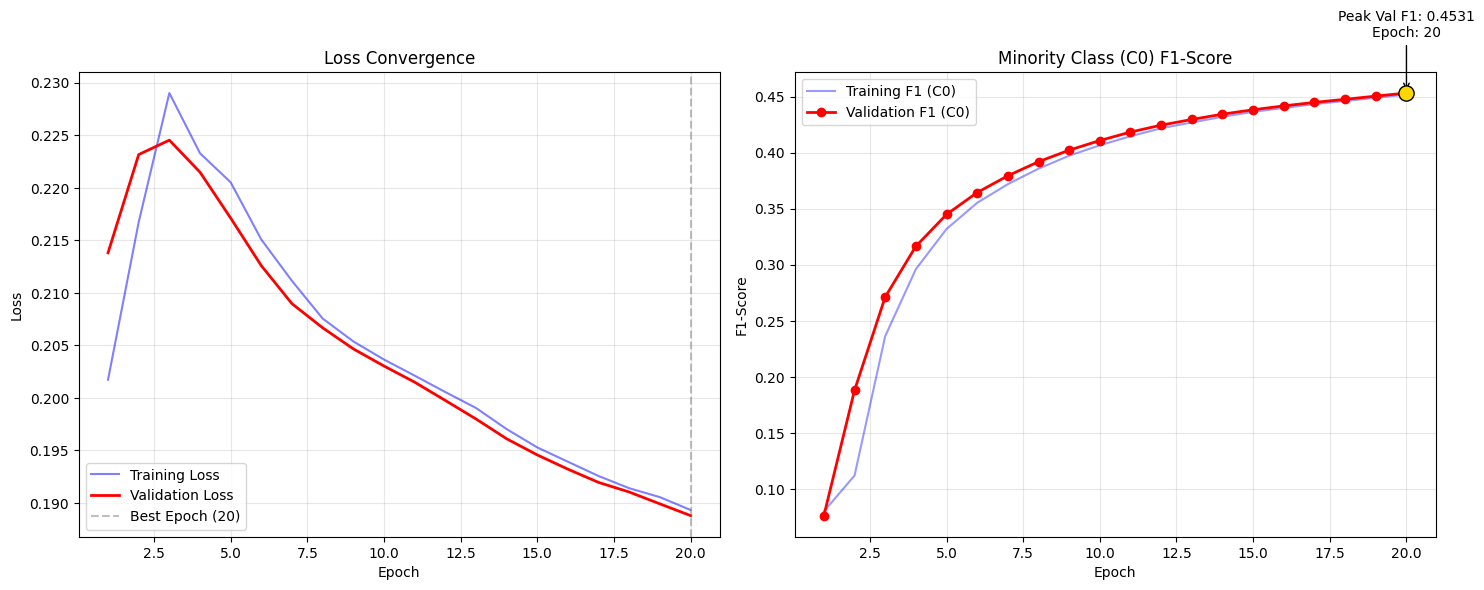

In [45]:
plot_learning_curves(history_path='/Users/adityaponnada/Downloads/time_study_data/within_user_training_history.json')

In [48]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
def find_optimal_threshold(model_path, X_val, Y_val):
    print(f"\nLoading best model from {model_path}...")
    
    # We map 'mask_generator_fn' (the name stored in the .h5) 
    # to the actual Python function defined above.
    try:
        model = load_model(
            model_path,
            custom_objects={
                'optimized_loss_fn': optimized_loss_fn,
                'optimized_f1_class0': optimized_f1_class0,
                'mask_generator_fn': mask_generator_fn, # Map the named function
                'tf': tf
            },
            compile=False,
            safe_mode=False
        )
    except Exception as e:
        print("\n" + "!"*60)
        print("[!] LOADING ERROR: Could not rebuild the model.")
        print("Update your TRAINING script to use 'mask_generator_fn' instead of 'lambda'.")
        print("!"*60)
        print(f"Error Details: {e}")
        return None, None

    all_probs = []
    all_true = []

    print(f"Generating predictions for {X_val.shape[0]} users...")
    for u in range(len(X_val)):
        # Predict on user sequence: Input (1, 4, 3967, 40)
        probs = model.predict(X_val[u:u+1], verbose=0)
        y_true_flat = Y_val[u].flatten()
        y_prob_flat = probs.flatten()
        mask = y_true_flat != SENTINEL_VALUE
        all_true.extend(y_true_flat[mask])
        all_probs.extend(y_prob_flat[mask])

    all_true = np.array(all_true)
    all_probs = np.array(all_probs)
    
    # Calculate Precision-Recall curve targeting Class 0 (Non-Response)
    precision, recall, thresholds = precision_recall_curve(1.0 - all_true, 1.0 - all_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    best_idx = np.argmax(f1_scores)
    max_f1 = f1_scores[best_idx]
    
    # The threshold for Class 0 (probability of being busy)
    best_thresh_c0 = thresholds[best_idx]
    # The threshold for Class 1 (probability of response, the model's actual output)
    best_thresh_c1 = 1.0 - best_thresh_c0

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores[:-1], color='darkorange', lw=3, label='F1 Score (Class 0)')
    
    # Indicate best threshold with a vertical line and a scatter point
    plt.axvline(best_thresh_c0, color='red', linestyle='--', alpha=0.6)
    plt.scatter(best_thresh_c0, max_f1, color='red', s=100, zorder=5, label='Optimal Point')
    
    # Detailed annotation at the peak
    plt.annotate(f'Max F1: {max_f1:.4f}\nOptimal Thresh (Busy): {best_thresh_c0:.4f}\nOptimal Thresh (Resp): {best_thresh_c1:.4f}', 
                 xy=(best_thresh_c0, max_f1), 
                 xytext=(best_thresh_c0 + 0.05, max_f1 - 0.1),
                 bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="red", alpha=0.8),
                 arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))

    plt.title('Threshold Optimization: F1-Score (Class 0) vs. Probability Threshold')
    plt.xlabel('Probability Threshold for "Busy" (Class 0)')
    plt.ylabel('F1 Score')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

    print(f"\n--- THRESHOLD TUNING COMPLETE ---")
    print(f"Max Validation F1 (Class 0):         {max_f1:.4f}")
    print(f"Optimal Threshold (Original Scale): {best_thresh_c1:.4f}")
    
    return best_thresh_c1, max_f1


Loading best model from best_within_user_gtcn.h5...
Generating predictions for 100 users...


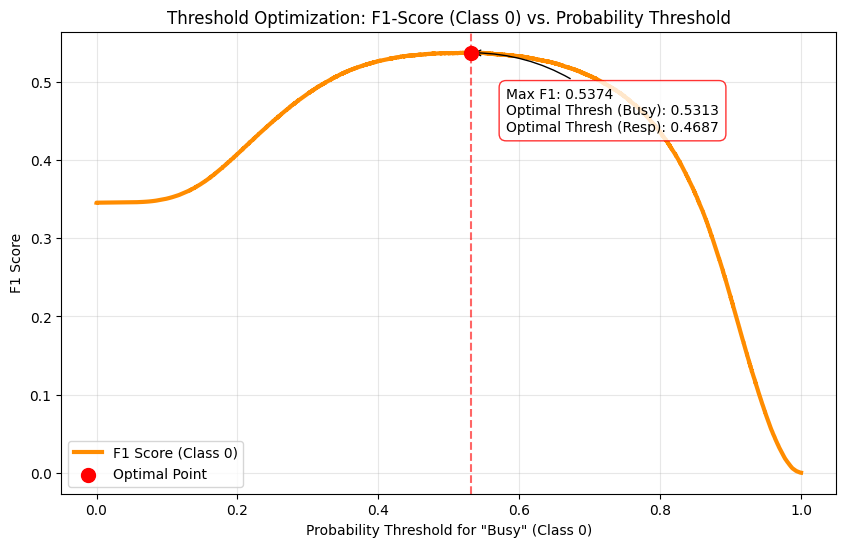


--- THRESHOLD TUNING COMPLETE ---
Max Validation F1 (Class 0):         0.5374
Optimal Threshold (Original Scale): 0.4687


In [49]:
opt_thresh, best_f1 = find_optimal_threshold('best_within_user_gtcn.h5', X_va, Y_va)

In [50]:
print(f'Optimal Threshold for Class 1: {opt_thresh}, Best F1 Score: {best_f1}')

Optimal Threshold for Class 1: 0.46866095066070557, Best F1 Score: 0.5373735572195133


## Test on held out data

Read the pre processed held out data

In [51]:
heldout_df = pd.read_csv('/Users/adityaponnada/Downloads/time_study_data/processed_features_heldout.csv')
heldout_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,animateshowerclothes@timestudy_com,1,0,1.0,0.0,1,0.000586,NaN,NaN,860.983333,...,0,0,0,0,0,0,0,0,0,0
1,animateshowerclothes@timestudy_com,0,0,1.0,1.0,1,0.001221,NaN,NaN,838.000000,...,0,0,0,0,0,0,0,0,0,0
2,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.000794,NaN,NaN,827.983333,...,0,0,0,0,0,0,0,0,0,0
3,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003441,NaN,NaN,817.983333,...,0,0,0,0,0,0,0,0,0,0
4,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003723,NaN,NaN,781.983333,...,0,0,0,0,0,0,0,0,0,0


In [52]:
heldout_df['participant_id'].nunique()

36

### Impute missing data

In [53]:
heldout_df = impute_test_with_medians_and_ffill(heldout_df, medians, verbose=True)

Imputing 32 columns (excluding {'participant_id', 'outcome'} and prefix "mi_")
Filled 211319 NaNs in column "in_battery_saver_mode" with median 0.0
Filled 211319 NaNs in column "charging_status" with median 0.0
Filled 58787 NaNs in column "dist_from_home" with median 0.0163402335633633
Filled 94616 NaNs in column "is_phone_locked" with median 1.0
Filled 94660 NaNs in column "last_phone_usage" with median 5.0
Filled 147 NaNs in column "closeness_to_sleep_time" with median 471.93333333333334
Filled 147 NaNs in column "closeness_to_wake_time" with median 451.01666666666665
Filled 23990 NaNs in column "mims_5min" with median 34.40816003213172


In [54]:
heldout_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,mi_time_of_day_Night,mi_location_category_Home,mi_location_category_Other,mi_location_category_School,mi_location_category_Transit,mi_location_category_Work,mi_wake_day_part_0.0,mi_wake_day_part_1.0,mi_wake_day_part_2.0,mi_wake_day_part_3.0
0,animateshowerclothes@timestudy_com,1,0,1.0,0.0,1,0.000586,1.0,5.0,860.983333,...,0,0,0,0,0,0,0,0,0,0
1,animateshowerclothes@timestudy_com,0,0,1.0,1.0,1,0.001221,1.0,5.0,838.000000,...,0,0,0,0,0,0,0,0,0,0
2,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.000794,1.0,5.0,827.983333,...,0,0,0,0,0,0,0,0,0,0
3,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003441,1.0,5.0,817.983333,...,0,0,0,0,0,0,0,0,0,0
4,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,0.003723,1.0,5.0,781.983333,...,0,0,0,0,0,0,0,0,0,0


Only keep the same columns as the training set

In [55]:
training_cols = train_df.columns
training_cols
print(len(training_cols))
print(training_cols)

42
Index(['participant_id', 'outcome', 'is_weekend', 'in_battery_saver_mode',
       'charging_status', 'screen_on', 'dist_from_home', 'is_phone_locked',
       'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time',
       'mims_5min', 'days_in_study', 'completion_24h', 'completion_1h',
       'time_between_prompts', 'time_since_last_answered',
       'completion_since_wake', 'completion_since_start',
       'time_of_day_Afternoon', 'time_of_day_Early Morning',
       'time_of_day_Evening', 'time_of_day_Late Night', 'time_of_day_Morning',
       'time_of_day_Night', 'location_category_Home',
       'location_category_Other', 'location_category_School',
       'location_category_Transit', 'location_category_Work',
       'wake_day_part_0.0', 'wake_day_part_1.0', 'wake_day_part_2.0',
       'wake_day_part_3.0', 'mi_in_battery_saver_mode', 'mi_charging_status',
       'mi_dist_from_home', 'mi_is_phone_locked', 'mi_last_phone_usage',
       'mi_closeness_to_sleep_time', '

In [56]:
heldout_df = heldout_df[training_cols]
print(heldout_df.shape[1])
print(heldout_df.shape[0])

42
406382


Scale held out data with z-normalization

In [57]:
heldout_df = z_normalize_test_using_global_mean(heldout_df, global_means, cols_to_scale=None, verbose=True)

Completed z-normalization of test data for columns: ['dist_from_home', 'last_phone_usage', 'closeness_to_sleep_time', 'closeness_to_wake_time', 'mims_5min', 'completion_24h', 'completion_1h', 'time_between_prompts', 'time_since_last_answered', 'completion_since_wake', 'completion_since_start']


In [58]:
heldout_df.head()

,participant_id,outcome,is_weekend,in_battery_saver_mode,charging_status,screen_on,dist_from_home,is_phone_locked,last_phone_usage,closeness_to_sleep_time,...,wake_day_part_2.0,wake_day_part_3.0,mi_in_battery_saver_mode,mi_charging_status,mi_dist_from_home,mi_is_phone_locked,mi_last_phone_usage,mi_closeness_to_sleep_time,mi_closeness_to_wake_time,mi_mims_5min
0,animateshowerclothes@timestudy_com,1,0,1.0,0.0,1,-132.068334,1.0,-0.523579,1.731305,...,0,0,0,0,0,1,1,0,0,0
1,animateshowerclothes@timestudy_com,0,0,1.0,1.0,1,-132.067381,1.0,-0.523579,1.628109,...,0,0,0,0,0,1,1,0,0,0
2,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,-132.068022,1.0,-0.523579,1.583133,...,0,0,0,0,0,1,1,0,0,0
3,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,-132.064051,1.0,-0.523579,1.538232,...,0,0,0,0,0,1,1,0,0,0
4,animateshowerclothes@timestudy_com,0,0,0.0,1.0,1,-132.063628,1.0,-0.523579,1.376590,...,0,0,0,0,0,1,1,0,0,0


In [59]:
# /Users/adityaponnada/Downloads/time_study_data/
heldout_df.to_csv('/Users/adityaponnada/Downloads/time_study_data/hybrid_heldout_scaled.csv', index=False)

### prepare held out tensors

In [60]:
## Get max number of pbservations for a given participant
try:
    counts = heldout_df['participant_id'].value_counts().sort_index()
    print('Number of observations per participant_id:')
    print(counts.to_string())
    # store the maximum count in obs_len
    ho_obs_len = int(counts.max()) if not counts.empty else 0
    print(f'ho_obs_len (max observations per participant) = {ho_obs_len}')
except NameError:
    print('heldout_df is not defined. Run the split to create heldout_df first.')
    ho_obs_len = None
except Exception as e:
    print('Error computing observation counts:', e)
    ho_obs_len = None

Number of observations per participant_id:
participant_id
animateshowerclothes@timestudy_com           9792
atlanticchefhatchet@timestudy_com           13238
beavertomatoupscale@timestudy_com           13099
bondingcoasterdirtiness@timestudy_com       13174
childhoodmovingmagnify@timestudy_com        14805
cohesiveprotractfavored@timestudy_com       14288
collisionmolarbreeze@timestudy_com           8292
congestedculpritsaved@timestudy_com         11542
congestedtapssneer@timestudy_com             8128
crestedserpentspongy@timestudy_com          11927
dimnesscranialunheard@timestudy_com         13908
enjoyergoofinessgrudge@timestudy_com        10457
faucetsquealingcatapult@timestudy_com       11557
feistydaycarelung@timestudy_com             12349
fracturerepurposealgebra@timestudy_com      10698
genderradiantlycharging@timestudy_com       15169
gentlykittenthaw@timestudy_com              11480
idealistsustainerexpansive@timestudy_com     9647
lardcapablemud@timestudy_com              

In [61]:
# --- 1. GLOBAL CONSTANTS (Must match Training/Validation) ---
MAX_TIME_SLOTS = ho_obs_len 
L_CHUNK = 3967 
NUM_CHUNKS = 4 
NUM_FEATURES = n_feature_cols # Adjust this if you filtered your features during training
SENTINEL_VALUE = 999.0

# --- 2. PREPROCESSING PIPELINE ---

def preprocess_held_out_data(df):
    """
    Converts scaled/imputed held-out DataFrame into 4D chunked tensors.
    """
    print(f"\nPreparing held-out tensors for {len(df['participant_id'].unique())} users...")
    
    # CRITICAL FIX: Explicitly ensure the padding length is a multiple of L_CHUNK.
    # 3967 * 4 = 15868
    required_len = NUM_CHUNKS * L_CHUNK 
    
    grouped = df.groupby('participant_id')
    X_list, Y_list, p_ids = [], [], []
    
    for p_id, group in grouped:
        p_ids.append(p_id)
        # Drop metadata and target to isolate features
        X_seq = group.drop(columns=['participant_id', 'outcome']).values 
        Y_seq = group['outcome'].values.astype('float32').reshape(-1, 1) 
        X_list.append(X_seq)
        Y_list.append(Y_seq)

    # Pad to exactly required_len (15,868 steps)
    X_padded = pad_sequences(X_list, maxlen=required_len, padding='post', value=SENTINEL_VALUE, dtype='float32')
    Y_padded = pad_sequences(Y_list, maxlen=required_len, padding='post', value=SENTINEL_VALUE, dtype='float32')
    
    # Reshape to 4D: (Users, 4 Chunks, 3967 steps, Features)
    n_users = len(p_ids)
    X_4d = X_padded.reshape(n_users, NUM_CHUNKS, L_CHUNK, X_padded.shape[-1])
    Y_4d = Y_padded.reshape(n_users, NUM_CHUNKS, L_CHUNK, 1)
    
    print(f"Padding/Chunking complete. Shape: {X_4d.shape}")
    return X_4d, Y_4d, p_ids

In [62]:
X_final, Y_final, heldout_pids = preprocess_held_out_data(heldout_df)


Preparing held-out tensors for 36 users...
Padding/Chunking complete. Shape: (36, 4, 3967, 40)


### Load the best model and run final eval

In [63]:
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def run_final_test_report(model_path, X_test, Y_test, threshold=0.5):
    """
    Generates a full classification report and confusion matrix for held-out users.
    """
    print(f"\nLoading model for final test: {model_path}")
    model = load_model(
        model_path,
        custom_objects={
            'optimized_loss_fn': optimized_loss_fn,
            'optimized_f1_class0': optimized_f1_class0,
            'mask_generator_fn': mask_generator_fn,
            'tf': tf
        },
        compile=False,
        safe_mode=False
    )

    all_true, all_pred = [], []
    
    print("Generating predictions on held-out set...")
    for u in range(len(X_test)):
        probs = model.predict(X_test[u:u+1], verbose=0)
        y_true = Y_test[u].flatten()
        y_prob = probs.flatten()
        
        mask = y_true != SENTINEL_VALUE
        y_true_real = y_true[mask]
        
        # Binary decision using the optimal threshold
        y_pred_real = (y_prob[mask] > threshold).astype(int)
        
        all_true.extend(y_true_real)
        all_pred.extend(y_pred_real)

    print("\n" + "="*45)
    print(f"     FINAL HELD-OUT TEST REPORT (N={len(X_test)})")
    print("="*45)
    print(classification_report(all_true, all_pred, target_names=['Busy (C0)', 'Response (C1)']))
    
    # Normalized Confusion Matrix
    cm = confusion_matrix(all_true, all_pred, normalize='true')
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['Pred Busy', 'Pred Resp'], 
                yticklabels=['Actual Busy', 'Actual Resp'])
    plt.title(f'Normalized Confusion Matrix ({len(X_test)} Unseen Users)')
    plt.show()

    return f1_score(all_true, all_pred, pos_label=0)


Loading model for final test: best_within_user_gtcn.h5
Generating predictions on held-out set...

     FINAL HELD-OUT TEST REPORT (N=36)
               precision    recall  f1-score   support

    Busy (C0)       0.50      0.60      0.55     70133
Response (C1)       0.91      0.87      0.89    336249

     accuracy                           0.83    406382
    macro avg       0.71      0.74      0.72    406382
 weighted avg       0.84      0.83      0.83    406382



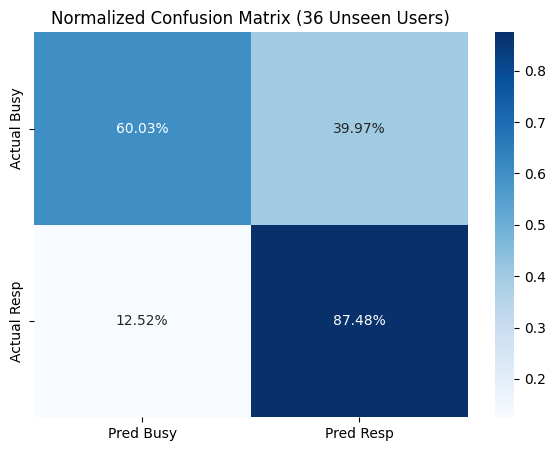

In [65]:
f1_val = run_final_test_report('best_within_user_gtcn.h5', X_final, Y_final, threshold=0.47)

### Get f1 distribution

In [66]:
def evaluate_f1_distribution(model_path, X_test, Y_test, participant_ids, threshold=0.47):
    """
    Calculates Class 0 F1 score for each individual participant and plots the distribution.
    Returns a DataFrame containing participant_id and f1_score.
    """
    print(f"\nAnalyzing F1 distribution for {len(X_test)} participants...")
    
    model = load_model(
        model_path,
        custom_objects={
            'optimized_loss_fn': optimized_loss_fn,
            'optimized_f1_class0': optimized_f1_class0,
            'mask_generator_fn': mask_generator_fn,
            'tf': tf
        },
        compile=False,
        safe_mode=False
    )

    results_data = []
    
    for u in range(len(X_test)):
        # Predict for single user
        probs = model.predict(X_test[u:u+1], verbose=0)
        y_true = Y_test[u].flatten()
        y_prob = probs.flatten()
        
        # Remove padding
        mask = y_true != SENTINEL_VALUE
        if not np.any(mask): continue
            
        y_true_real = y_true[mask]
        y_pred_real = (y_prob[mask] > threshold).astype(int)
        
        # Calculate F1 specifically for Class 0 (Non-Response/Busy)
        score = f1_score(y_true_real, y_pred_real, pos_label=0, zero_division=0)
        
        results_data.append({
            'participant_id': participant_ids[u],
            'f1_score': score
        })

    # Create the DataFrame
    df_results = pd.DataFrame(results_data)
    
    # Descriptive Stats
    stats = df_results['f1_score'].describe()
    mean_val = df_results['f1_score'].mean()
    median_val = df_results['f1_score'].median()
    
    print("\n" + "="*45)
    print("      F1-SCORE (CLASS 0) DESCRIPTIVE STATS")
    print("="*45)
    print(stats)
    print("="*45)

    # Plotting
    plt.figure(figsize=(12, 6))
    
    # Histogram + KDE
    sns.histplot(df_results['f1_score'], bins=15, kde=True, color='teal', alpha=0.6)
    
    # Annotate Mean and Median
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
    plt.axvline(median_val, color='darkblue', linestyle='-.', linewidth=2, label=f'Median: {median_val:.3f}')
    
    # Add text markers for the lines
    plt.text(mean_val + 0.01, plt.ylim()[1]*0.9, f'Mean: {mean_val:.3f}', color='red', fontweight='bold')
    plt.text(median_val - 0.15, plt.ylim()[1]*0.8, f'Median: {median_val:.3f}', color='darkblue', fontweight='bold')

    plt.title('Distribution of Individual F1-Scores (Class 0) Across Participants', fontsize=14)
    plt.xlabel('F1-Score (Minority Class: Busy)', fontsize=12)
    plt.ylabel('Number of Participants', fontsize=12)
    plt.xlim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    return df_results


Analyzing F1 distribution for 36 participants...

      F1-SCORE (CLASS 0) DESCRIPTIVE STATS
count    36.000000
mean      0.488608
std       0.137604
min       0.169373
25%       0.440214
50%       0.493173
75%       0.559671
max       0.761992
Name: f1_score, dtype: float64


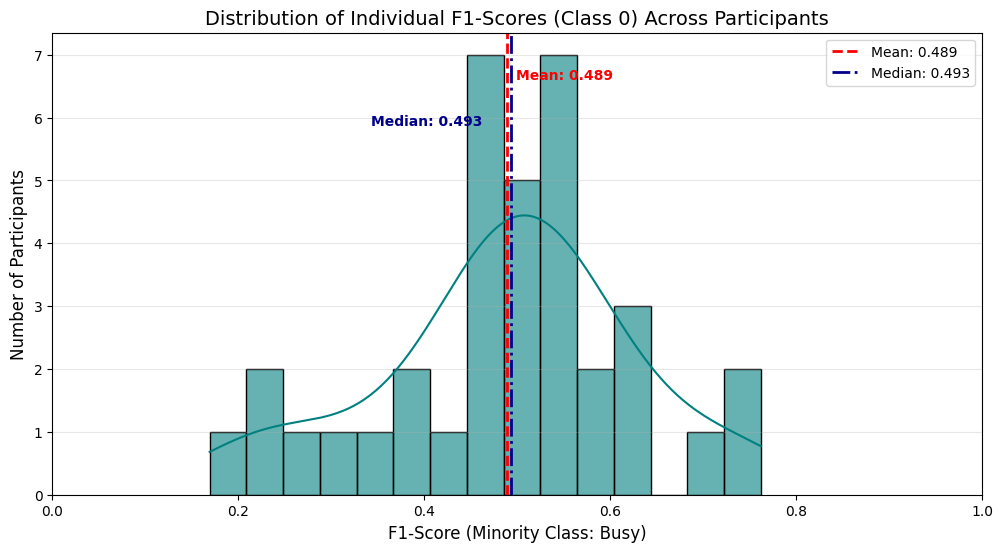

In [71]:
f1_dist = evaluate_f1_distribution('best_within_user_gtcn.h5', X_final, Y_final, heldout_pids, threshold=opt_thresh)

In [68]:
f1_dist.head()

,participant_id,f1_score
0,animateshowerclothes@timestudy_com,0.169373
1,atlanticchefhatchet@timestudy_com,0.721534
2,beavertomatoupscale@timestudy_com,0.446813
3,bondingcoasterdirtiness@timestudy_com,0.563272
4,childhoodmovingmagnify@timestudy_com,0.501453


In [69]:
f1_0_df = f1_dist[f1_dist['f1_score'] < 0.1]
f1_0_df

,participant_id,f1_score


In [70]:
f1_dist.to_csv('/Users/adityaponnada/Downloads/time_study_data/hybrid_f1_scores.csv', index=False)